## Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
import numpy as np
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import psutil
import os
import platform
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Week 12\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device Setup & Reproducibility

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# Optional: set seeds
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

output_dir = "PiT Tiny"
os.makedirs(output_dir, exist_ok=True)

✅ Using device: cuda


## Data Preparation

In [3]:
# Use ImageNet normalization + resize to 224x224 (required by PiT Tiny)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Train: {len(train_dataset)} images | Test: {len(test_dataset)} images")

✅ Train: 50000 images | Test: 10000 images


## Model Setup – Load Pretrained

In [4]:
# Load PiT Tiny from timm (pretrained on ImageNet-1k)
print("📥 Loading PiT Tiny from timm...")
model = timm.create_model(
    'pit_ti_distilled_224.in1k',
    pretrained=True,
    num_classes=10
)

# Freeze all but the head
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

model = model.to(device)
print("✅ Model output shape test:", model(torch.randn(1, 3, 224, 224).to(device)).shape)

📥 Loading PiT Tiny from timm...
✅ Model output shape test: torch.Size([1, 10])


In [5]:
def get_model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params
model_size_mb = get_model_size_mb(model)

print("=== MODEL PARAMETER ===")
print(f"• Total Parameters:         {total_params:,}")
print(f"• Trainable Parameters:     {trainable_params:,}")
print(f"• Non-Trainable Parameters: {non_trainable_params:,}")
print(f"• Model Size (FP32):        {model_size_mb:.2f} MB")

=== MODEL PARAMETER ===
• Total Parameters:         4,595,476
• Trainable Parameters:     5,140
• Non-Trainable Parameters: 4,590,336
• Model Size (FP32):        17.53 MB


## Training Configuration

In [6]:
NUM_EPOCHS = 20
best_val_acc = 0.0

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Track metrics for learning curves
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

## Training & Validation Loop

In [7]:
def evaluate_loader(loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(loader)
    return avg_loss, acc, all_preds, all_labels

# Training loop
print("🚀 Starting training...\n")
total_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    # --- Training ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = outputs.max(1)
        train_total += labels.size(0)
        train_correct += preds.eq(labels).sum().item()
    
    train_acc = train_correct / train_total
    train_loss /= len(train_loader)
    
    # --- Validation ---
    val_loss, val_acc, _, _ = evaluate_loader(test_loader)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_path = os.path.join(output_dir, "pit_tiny_cifar10_best.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Epoch {epoch+1}: 🥇 New best accuracy! Saved model.")
    
    # Update LR
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f} | "
        f"LR: {current_lr:.2e}\n"
    )

total_time = time.time() - total_start_time
print(f"\n✅ Training finished. Best validation accuracy: {best_val_acc:.2f}")
print(f"🕒 Total training time: {total_time/60:.2f} minutes")

🚀 Starting training...

Epoch 1: 🥇 New best accuracy! Saved model.
Epoch 1/20 | Train Loss: 0.8306, Acc: 0.88 | Val Loss: 0.7610, Acc: 0.91 | LR: 9.94e-04

Epoch 2: 🥇 New best accuracy! Saved model.
Epoch 2/20 | Train Loss: 0.7486, Acc: 0.92 | Val Loss: 0.7565, Acc: 0.91 | LR: 9.76e-04

Epoch 3: 🥇 New best accuracy! Saved model.
Epoch 3/20 | Train Loss: 0.7429, Acc: 0.92 | Val Loss: 0.7495, Acc: 0.91 | LR: 9.46e-04

Epoch 4: 🥇 New best accuracy! Saved model.
Epoch 4/20 | Train Loss: 0.7390, Acc: 0.92 | Val Loss: 0.7533, Acc: 0.92 | LR: 9.05e-04

Epoch 5/20 | Train Loss: 0.7380, Acc: 0.92 | Val Loss: 0.7557, Acc: 0.91 | LR: 8.54e-04

Epoch 6: 🥇 New best accuracy! Saved model.
Epoch 6/20 | Train Loss: 0.7375, Acc: 0.92 | Val Loss: 0.7508, Acc: 0.92 | LR: 7.94e-04

Epoch 7/20 | Train Loss: 0.7359, Acc: 0.92 | Val Loss: 0.7501, Acc: 0.91 | LR: 7.27e-04

Epoch 8: 🥇 New best accuracy! Saved model.
Epoch 8/20 | Train Loss: 0.7353, Acc: 0.92 | Val Loss: 0.7490, Acc: 0.92 | LR: 6.55e-04

Epoch 

## Learning Curves

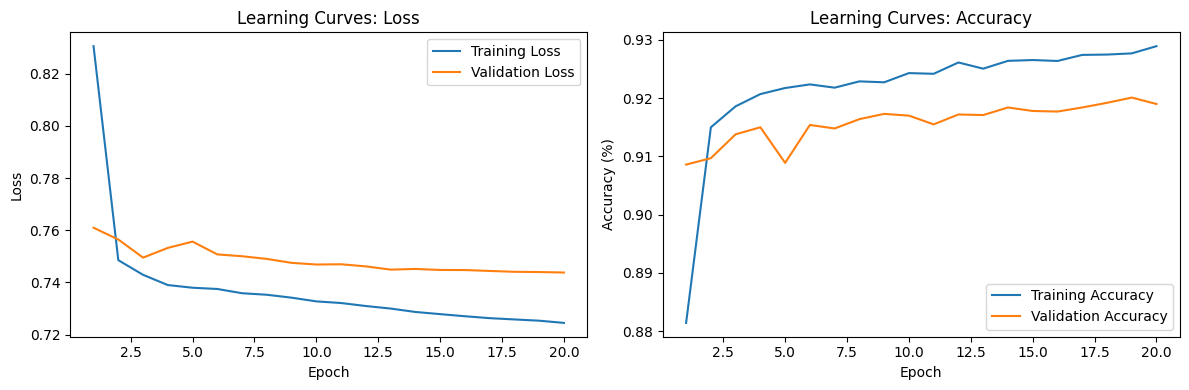

In [12]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Learning Curves: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Training Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Learning Curves: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()